In [1]:
import os
import glob
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_rel

In [2]:
def create_df_for_descr_ind_avg(max_arrays: int) -> pd.DataFrame:
    """Reads the data for all subjects and from both the individual and the average approach.
    It selects the array that is specified in max_arrays, if it exists. 
    
    Parameters
    ----------
    max_arrays : int
        The maximum number of arrays to read.
    
    Returns
    -------
    out_df : pd.DataFrame
        A dataframe used for descriptive stats:
        ["subject", "array_type", "hemisphere", "array", "total_dice", "prop_total_dice", 
        "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
    """
    array_types = ["3d", "utah"]
    
    ind_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/5_arrays_10x10x10/results/"
    avg_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/16_arrays_1x10x10/results/"
    results_paths = [ind_path, avg_path]
    
    ind_subs = os.listdir(ind_path)
    avg_subs = os.listdir(avg_path)
    subs_lists = [ind_subs, avg_subs]
    out_df = pd.DataFrame()
    arrays = [i for i in range(1, max_arrays + 1)]
    for sub_list, sub_path, array_tupe in zip(subs_lists, results_paths, array_types):
        if "exp" in sub_list:
            sub_list.remove("exp")
        if "fsaverage" in sub_list:
            sub_list.remove("fsaverage")
        for sub in sub_list:
            for hem in ["LH", "RH"]:
                hem_dir = os.path.join(sub_path, sub, hem)
                filenames = glob.glob(os.path.join(hem_dir, "*.csv"))
                # Assuming there's only one file in the directory, you can take the first one
                filename = [file for file in filenames if "best" in file][0]
                
                res_df = pd.read_csv(filename)        
                columns_to_select = ["array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                
                max_array_exists = arrays[-1] in res_df["array"].tolist()
                if max_array_exists:
                    for array in arrays:
                        arr_row = res_df[res_df["array"] == array]
                        selected_columns = arr_row[columns_to_select].copy()
                        selected_columns["subject"] = sub
                        selected_columns["hemisphere"] = hem
                        selected_columns["array_type"] = array_tupe
                        column_order = ["subject", "array_type", "hemisphere", "array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                        selected_columns = selected_columns[column_order]
                        out_df = pd.concat([out_df, selected_columns], ignore_index=True)
    return out_df

def create_df_for_3d_vs_utah() -> pd.DataFrame:
    """Reads the data for all subjects and from both the 3d and the utah array implementations.
    It selects the last array placed, regardless of its number or whether the same array
    was placed in the other hemisphere as well. 
    So in total it has (subs x hems x array_types) = (181 x 2 x 2) = 724 rows
    
    Returns
    -------
    out_df : pd.DataFrame
        A dataframe to be put in the AnovaRM function with columns:
        ["subject", "hemisphere", "array_type", "max_array", "total_dice", "prop_total_dice", 
        "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
    """
    array_types = ["3d", "utah"]
    
    ind_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/5_arrays_10x10x10/results/"
    avg_path = "/home/odysseas/Desktop/UU/thesis/BayesianOpt/16_arrays_1x10x10/results/"
    results_paths = [ind_path, avg_path]
    
    ind_subs = os.listdir(ind_path)
    avg_subs = os.listdir(avg_path)
    subs_lists = [ind_subs, avg_subs]
    out_df = pd.DataFrame()
    
    for sub_list, sub_path, array_type in zip(subs_lists, results_paths, array_types):
        if "exp" in sub_list:
            sub_list.remove("exp")
        if "fsaverage" in sub_list:
            sub_list.remove("fsaverage")
    
        for sub in sub_list:
            for hem in ["LH", "RH"]:
                hem_dir = os.path.join(sub_path, sub, hem)
                filenames = glob.glob(os.path.join(hem_dir, "*.csv"))
                # Assuming there's only one file in the directory, you can take the first one
                filename = [file for file in filenames if "best" in file][0]
                try:
                    res_df = pd.read_csv(filename)
                    res_df = res_df.iloc[-1:]    # select max array (the last row)
            
                    columns_to_select = ["array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                    selected_columns = res_df[columns_to_select].copy()
                    selected_columns["subject"] = sub
                    selected_columns["hemisphere"] = hem
                    selected_columns["array_type"] = array_type
                    column_order = ["subject", "hemisphere", "array_type", "array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]
                    selected_columns = selected_columns[column_order]
                    out_df = pd.concat([out_df, selected_columns], ignore_index=True)
                except FileNotFoundError as e:
                    print(f"File {filename} not found")
                    continue
    out_df.rename(columns={"array": "max_array"}, inplace=True)
    return out_df

In [3]:
def violin_plots_all(results_df: pd.DataFrame) -> None:
    """Creates violin plots for the cost function, given the df from create_df_for_ind_vs_avg().
    This df considers all 181 subjects from both hemispheres and array types and contains
    the last validly placed array."""
    total_observations = len(results_df.subject.unique())
    res_df = results_df.copy()
    res_df["total_dice_loss"] = 1 - res_df["total_dice"]
    res_df["array_yield_loss"] = 1 - res_df["array_yield"]
    dvs = ["cost", "total_dice_loss", "array_yield_loss", "total_HD"]
    dv_names = ["Cost", "Dice loss (1-dice)", "Yield loss (1-yield)", "Hellinger distance"]
    # yield is not meaningful because it's only for the last array
    dvs.remove("array_yield_loss")
    dv_names.remove("Yield loss (1-yield)")
    fig, axes = plt.subplots(nrows=1, ncols=len(dvs), figsize=(16, 8), sharex=True)
    for i, dv in enumerate(dvs):
        sns.violinplot(data=res_df, x="array_type", y=dv, hue="hemisphere", inner="box", split=True, ax=axes[i], order=["3d", "utah"])
        axes[i].legend(title="hemisphere", labels=["LH", "RH"], handles=axes[i].legend_.legend_handles)
        axes[i].set_title(f"{dv_names[i]} per array type", fontsize=16)
        axes[i].set_xlabel("", fontsize=16)
        axes[i].set_ylabel(dv_names[i], fontsize=16)
        axes[i].tick_params(axis="x", labelsize=16)
    fig.suptitle(f"Mean losses per array type (based on the last validly placed array) for all {total_observations} subjects", fontsize=24) #based on a total of {total_observations}
    fig.supxlabel("Array type", fontsize=20)
    plt.tight_layout()
    plt.savefig("./losses_violin_plots_exp3.png")
    plt.show()
    

def visualize_yield_loss(three_d_descriptives: pd.DataFrame, utah_descriptives: pd.DataFrame) -> None:
    """Creates and saves a plot for the yield loss."""

    dfs = [three_d_descriptives, utah_descriptives]
    xs = ["3d array", "utah array"]
    line_styles = ['-', '--']
    colors = {
        "3d array": {"LH": "blue", "RH": "orange"},
        "utah array": {"LH": "blue", "RH": "orange"}
    }
    marks = ["o", "v"]
    fig, ax = plt.subplots(figsize=(10, 6))

    for i, df in enumerate(dfs):
        sns.pointplot(x="array", y="array_yield_loss", hue="hemisphere", data=df,
                      ax=ax, linestyles=line_styles[i], markers=marks[i], palette=colors[xs[i]])
    
    # plt.setp(ax.collections, alpha=.3) #for the markers
    plt.setp(ax.lines, alpha=.4)       #for the lines
    ax.set_title("Mean yield loss per array", fontsize=24)
    ax.set_xlabel("Array", fontsize=20)
    ax.set_ylabel("Mean yield loss", fontsize=20)
    ax.tick_params(axis="x", labelsize=16)
    ax.legend(title="Array type and hemisphere", labels=["3d-LH", "3d-RH", "utah-LH", "utah-RH"], handles=ax.legend_.legend_handles)

    plt.tight_layout()
    plt.savefig("./yield_losses_exp3.png")
    plt.show()
    
    
def create_histograms(data) -> None:
    """Creates and saves histograms of the cost function by hemisphere and array type.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe generated by create_df_for_ind_vs_avg()
    """
    data_LH = data[data.hemisphere == "LH"]
    data_RH = data[data.hemisphere == "RH"]
    row = 0
    col = 0
    colors = ["green", "skyblue"]
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for hem, df in zip(["left", "right"], [data_LH, data_RH]):
        for array_type, array_type_name in zip(["3d", "utah"], ["3d", "Utah"]):
            array_type_df = df[df["array_type"] == array_type].reset_index(drop=True).copy()
            sns.histplot(data=array_type_df, x="cost", kde=False, color=colors[col], ax=axes[row, col])
            axes[row, col].set_xlabel(f"Cost for {array_type_name} array type", fontsize=14) if row == 1 else axes[row, col].set_xlabel("")
            axes[row, col].set_ylabel("")
            col += 1
        row += 1
        col = 0
    
    labels = ["Count for left hemisphere", "Count for right hemisphere"]
    for l, ax in zip(labels, axes):
        ax[0].set_ylabel(l, fontsize=14)
        
    fig.suptitle(f"Distribution of cost per array type and hemisphere", fontsize=24)
    plt.tight_layout()
    plt.savefig(f"./histograms_exp3.png")
    plt.show()

def get_descriptive_stats(all_arrays_df: list, array_type: str, hem: str) -> pd.DataFrame:
    """Gets descriptive statistics for the given array type and hemisphere.
    
    Parameters
    ----------
    all_arrays_df : list
        A list with all dataframes (one dataframe for each max array considered).
        The dataframes are created using create_df_for_descr_ind_avg(max_arrays).
    array_type : str
        The array type, one of "3d", "utah"
    hem : str
        The hemisphere, one of "LH", "RH"
    
    Returns
    -------
    descriptive_stats_df : pd.DataFrame
        A dataframe with descriptive statistics for the given array type and hemisphere, one row for each array.
        So it describes how many subs completed that array, with the average values.
    """
    descriptive_stats_df = pd.DataFrame()
    for df in all_arrays_df:
        array_type_hem_df = df[(df.array_type == array_type) & (df.hemisphere == hem)]
        max_array = array_type_hem_df.array.max()
        total_subs = len(array_type_hem_df.subject.unique())
        stats = array_type_hem_df.groupby(["hemisphere", "array"])[
            ["total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost",
             "prop_cost"]].mean().reset_index()
        stats = stats[stats["array"] == max_array].reset_index(drop=True)
        stats["total_subjects"] = total_subs
        stats["total_dice_loss"] = 1 - stats["total_dice"]
        stats["array_yield_loss"] = 1 - stats["array_yield"]
        column_order = ["array", "hemisphere", "total_subjects", "total_dice_loss", "prop_total_dice",
                        "array_yield_loss", "total_HD", "prop_total_hd", "cost", "prop_cost"]
        stats = stats[column_order]
        descriptive_stats_df = pd.concat([descriptive_stats_df, stats], ignore_index=True)

    return descriptive_stats_df

def get_mean_std(data: pd.DataFrame) -> None:
    """Prints the mean and standard deviation of the data by array type and hemisphere.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe generated by create_df_for_ind_vs_avg()
    """
    data_LH = data[data.hemisphere == "LH"]
    data_RH = data[data.hemisphere == "RH"]
    three_d_LH = data_LH[data_LH["array_type"] == "3d"]
    utah_LH = data_LH[data_LH["array_type"] == "utah"]
    three_d_RH = data_RH[data_RH["array_type"] == "3d"]
    utah_RH = data_RH[data_RH["array_type"] == "utah"]
    all_dfs = [three_d_LH, utah_LH, three_d_RH, utah_RH]
    names = ["three_d_LH", "utah_LH", "three_d_RH", "utah_RH"]
    for name, df in zip(names, all_dfs):
        mean = df["cost"].mean()
        std = df["cost"].std()
        print(f"data: {name}, mean: {mean}, std: {std}")
        
def run_paired_ttest(data: pd.DataFrame, dv: str) -> None:
    """Runs and prints two paired samples t-tests. One for each hemisphere. 
    The within subjects factor is the array type and the dv is the cost.
    The alternative hypothesis is one-sided: 3d < utah
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataframe generated by create_df_for_ind_vs_avg()
    """
    data_LH = data[data.hemisphere == "LH"]
    data_RH = data[data.hemisphere == "RH"]
    three_d_LH = data_LH[data_LH["array_type"] == "3d"]
    utah_LH = data_LH[data_LH["array_type"] == "utah"]
    three_d_RH = data_RH[data_RH["array_type"] == "3d"]
    utah_RH = data_RH[data_RH["array_type"] == "utah"]
    print(ttest_rel(three_d_LH[dv], utah_LH[dv], alternative="less"))
    print(ttest_rel(three_d_RH[dv], utah_RH[dv], alternative="less"))

In [4]:
list_3d_utah_dfs = []
for i in range(1, 17):
    df = create_df_for_descr_ind_avg(max_arrays=i)
    list_3d_utah_dfs.append(df)

In [5]:
ind_avg_hem_arr1 = create_df_for_descr_ind_avg(max_arrays=1)
ind_avg_hem_arr2 = create_df_for_descr_ind_avg(max_arrays=2)
ind_avg_hem_arr3 = create_df_for_descr_ind_avg(max_arrays=3)
ind_avg_hem_arr4 = create_df_for_descr_ind_avg(max_arrays=4)
ind_avg_hem_arr5 = create_df_for_descr_ind_avg(max_arrays=5)
ind_avg_list_all_array_dfs = [ind_avg_hem_arr1, ind_avg_hem_arr2, ind_avg_hem_arr3, ind_avg_hem_arr4, ind_avg_hem_arr5]

In [6]:
ind_avg_hem_arr5.head()

,subject,method,hemisphere,array,total_dice,prop_total_dice,array_yield,total_HD,prop_total_hd,cost,prop_cost
0,114823,ind,LH,1,0.191435,0.245009,0.609,0.850841,0.436150,2.628956,0.237749
1,114823,ind,LH,2,0.221360,0.283309,0.561,0.841391,0.463785,2.591980,0.261442
2,114823,ind,LH,3,0.222758,0.285098,0.296,0.840785,0.465556,2.603227,0.254236
3,114823,ind,LH,4,0.223341,0.285844,0.288,0.840519,0.466333,2.602778,0.254523
4,114823,ind,LH,5,0.232503,0.297570,0.327,0.835550,0.480864,2.586696,0.264828


In [38]:
ind_avg_list_all_array_dfs[0].head()

,subject,method,hemisphere,array,total_dice,prop_total_dice,array_yield,total_HD,prop_total_hd,cost,prop_cost
0,114823,ind,LH,1,0.191435,0.245009,0.609,0.850841,0.436150,2.628956,0.237749
1,114823,ind,RH,1,0.601614,0.694429,0.588,0.691783,0.714592,2.060769,0.600157
2,200311,ind,LH,1,0.283553,0.373494,0.441,0.826635,0.567088,2.521032,0.309707
3,200311,ind,RH,1,0.471554,0.593022,0.421,0.762771,0.685638,2.270167,0.470609
4,146129,ind,LH,1,0.239636,0.329377,0.531,0.841694,0.532326,2.575508,0.270404


In [6]:
three_d_descriptives_LH = get_descriptive_stats(list_3d_utah_dfs, "3d", "LH")
three_d_descriptives_RH = get_descriptive_stats(list_3d_utah_dfs, "3d", "RH")
utah_descriptives_LH = get_descriptive_stats(list_3d_utah_dfs, "utah", "LH")
utah_descriptives_RH = get_descriptive_stats(list_3d_utah_dfs, "utah", "RH")
three_d_descriptives = pd.concat([three_d_descriptives_LH, three_d_descriptives_RH], axis=0)
utah_descriptives = pd.concat([utah_descriptives_LH, utah_descriptives_RH], axis=0)

In [48]:
three_d_descriptives_LH

,array,hemisphere,total_subjects,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,LH,181,0.708030,0.394406,0.524133,0.826303,0.561050,2.510539,0.312013
1,2,LH,181,0.671418,0.443552,0.475912,0.811900,0.607056,2.457114,0.346110
2,3,LH,181,0.660305,0.458605,0.592713,0.808283,0.618783,2.448224,0.351778
3,4,LH,164,0.642082,0.481712,0.610457,0.801580,0.637070,2.424184,0.367252
4,5,LH,116,0.627636,0.497279,0.602017,0.796123,0.649327,2.403860,0.381003


In [49]:
utah_descriptives_LH

,array,hemisphere,total_subjects,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,LH,181,0.991988,0.010808,0.087845,0.977436,0.072743,2.923816,0.048566
1,2,LH,181,0.984985,0.020306,0.083149,0.968257,0.102514,2.907400,0.059020
2,3,LH,181,0.979601,0.027695,0.095138,0.962650,0.120896,2.897008,0.065623
3,4,LH,181,0.973689,0.035637,0.101768,0.957265,0.138172,2.886042,0.072616
4,5,LH,181,0.969091,0.041916,0.084033,0.953348,0.150953,2.876641,0.078590
5,6,LH,181,0.964747,0.047841,0.111547,0.949904,0.162154,2.870228,0.082659
6,7,LH,181,0.960923,0.053000,0.107956,0.947002,0.171492,2.863323,0.087070
7,8,LH,181,0.955456,0.060448,0.131878,0.943419,0.183094,2.855469,0.092053
8,9,LH,181,0.951858,0.065269,0.130387,0.941065,0.190587,2.849442,0.095896
9,10,LH,181,0.947593,0.071005,0.121547,0.938421,0.198966,2.842092,0.100582


In [52]:
utah_descriptives_RH

,array,hemisphere,total_subjects,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,1,RH,181,0.987325,0.015574,0.075856,0.971984,0.076601,2.913101,0.055784
1,2,RH,181,0.974346,0.031548,0.090221,0.958889,0.112587,2.887747,0.072083
2,3,RH,181,0.964336,0.043981,0.096464,0.950671,0.135351,2.869830,0.083585
3,4,RH,181,0.953839,0.056961,0.126796,0.943181,0.155901,2.853360,0.094152
4,5,RH,181,0.944353,0.068638,0.121989,0.937140,0.172422,2.837592,0.104292
5,6,RH,181,0.936992,0.077726,0.118122,0.932634,0.184821,2.825532,0.112036
6,7,RH,181,0.929461,0.086999,0.126961,0.928392,0.196226,2.814201,0.119293
7,8,RH,181,0.924412,0.093254,0.134254,0.925562,0.203987,2.806687,0.124110
8,9,RH,181,0.916576,0.102863,0.162099,0.921458,0.215196,2.796139,0.130896
9,10,RH,181,0.909904,0.111136,0.160994,0.918036,0.224671,2.785991,0.137410


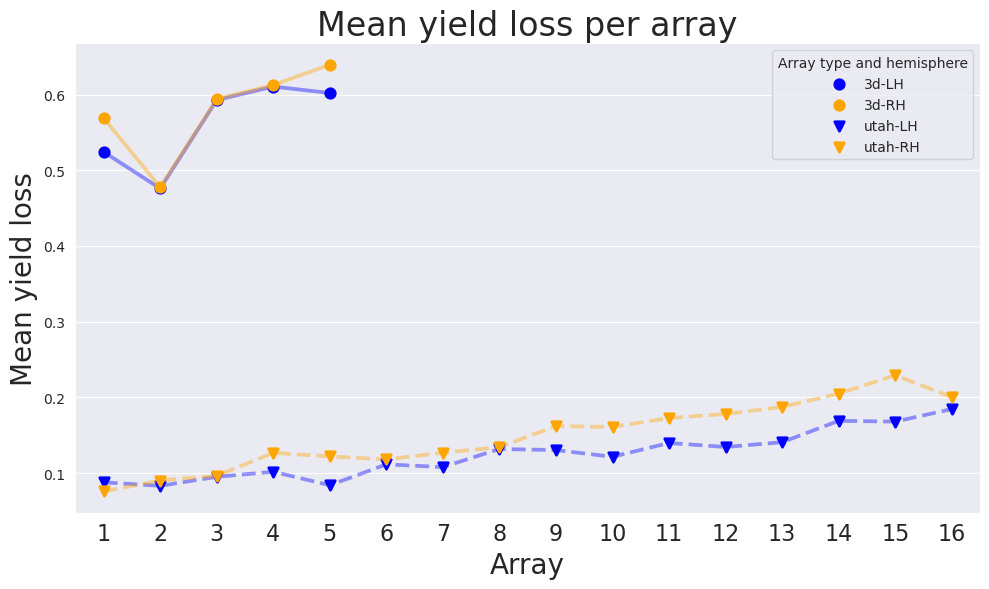

In [7]:
visualize_yield_loss(three_d_descriptives, utah_descriptives)

In [8]:
data = create_df_for_3d_vs_utah()

In [9]:
data.groupby(["array_type", "hemisphere", "max_array"])[["subject"]].count()

subject
array_type hemisphere max_array         
3d         LH         3               17
                      4               48
                      5              116
           RH         3               11
                      4               64
                      5              106
utah       LH         14               9
                      15              35
                      16             137
           RH         13               3
                      14               3
                      15              42
                      16             133

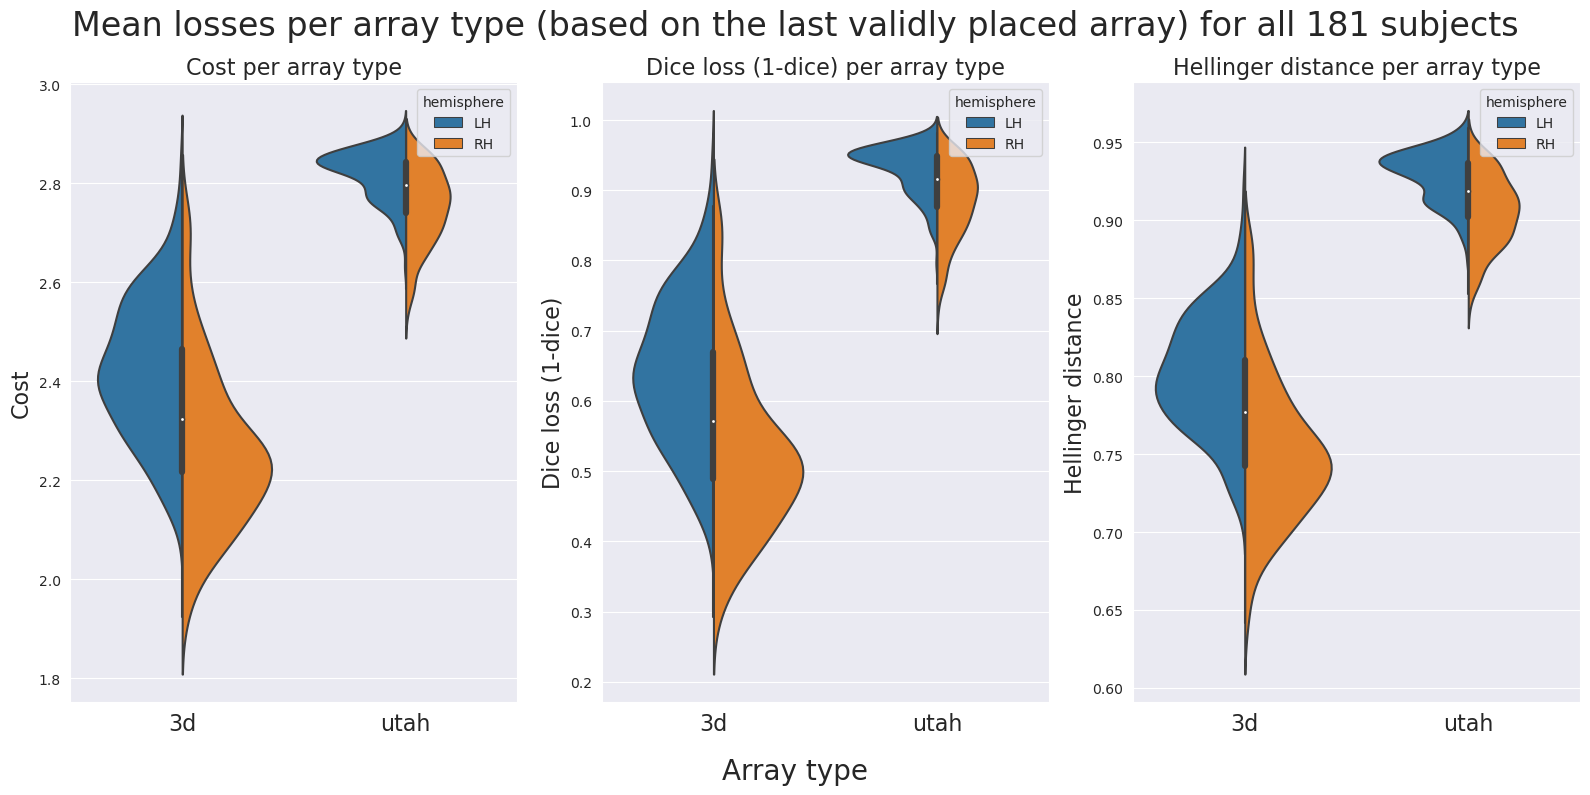

In [102]:
violin_plots_all(data)

In [11]:
get_mean_std(data)

data: three_d_LH, mean: 2.423035588273815, std: 0.13934318431290058
data: utah_LH, mean: 2.8182041909544564, std: 0.05015254474364906
data: three_d_RH, mean: 2.256895704216843, std: 0.16193447446226256
data: utah_RH, mean: 2.74961907051832, std: 0.07645370763324802


In [10]:
run_paired_ttest(data, "cost")

TtestResult(statistic=-43.95871143383575, pvalue=1.7260208008145034e-98, df=180)
TtestResult(statistic=-51.695495941874015, pvalue=3.103976168942206e-110, df=180)


In [23]:
total_subs = len(data.subject.unique())
stats = data.groupby(["hemisphere", "array_type"])[["max_array", "total_dice", "prop_total_dice", "array_yield", "total_HD", "prop_total_hd", "cost", "prop_cost"]].mean().reset_index()
stats["total_subjects"] = total_subs
stats["total_dice_loss"] = 1 - stats["total_dice"]
stats["array_yield_loss"] = 1 - stats["array_yield"]
column_order = ["array_type", "hemisphere", "max_array", "total_subjects",  "total_dice_loss", "prop_total_dice", "array_yield_loss", "total_HD", "prop_total_hd", "cost", "prop_cost"]
stats = stats[column_order]

In [24]:
round(stats, 2)

,array_type,hemisphere,max_array,total_subjects,total_dice_loss,prop_total_dice,array_yield_loss,total_HD,prop_total_hd,cost,prop_cost
0,3d,LH,4.55,181,0.64,0.48,0.61,0.80,0.64,2.42,0.37
1,utah,LH,15.71,181,0.93,0.09,0.18,0.93,0.23,2.82,0.12
2,3d,RH,4.52,181,0.52,0.59,0.63,0.75,0.68,2.26,0.48
3,utah,RH,15.69,181,0.88,0.14,0.23,0.91,0.26,2.75,0.16


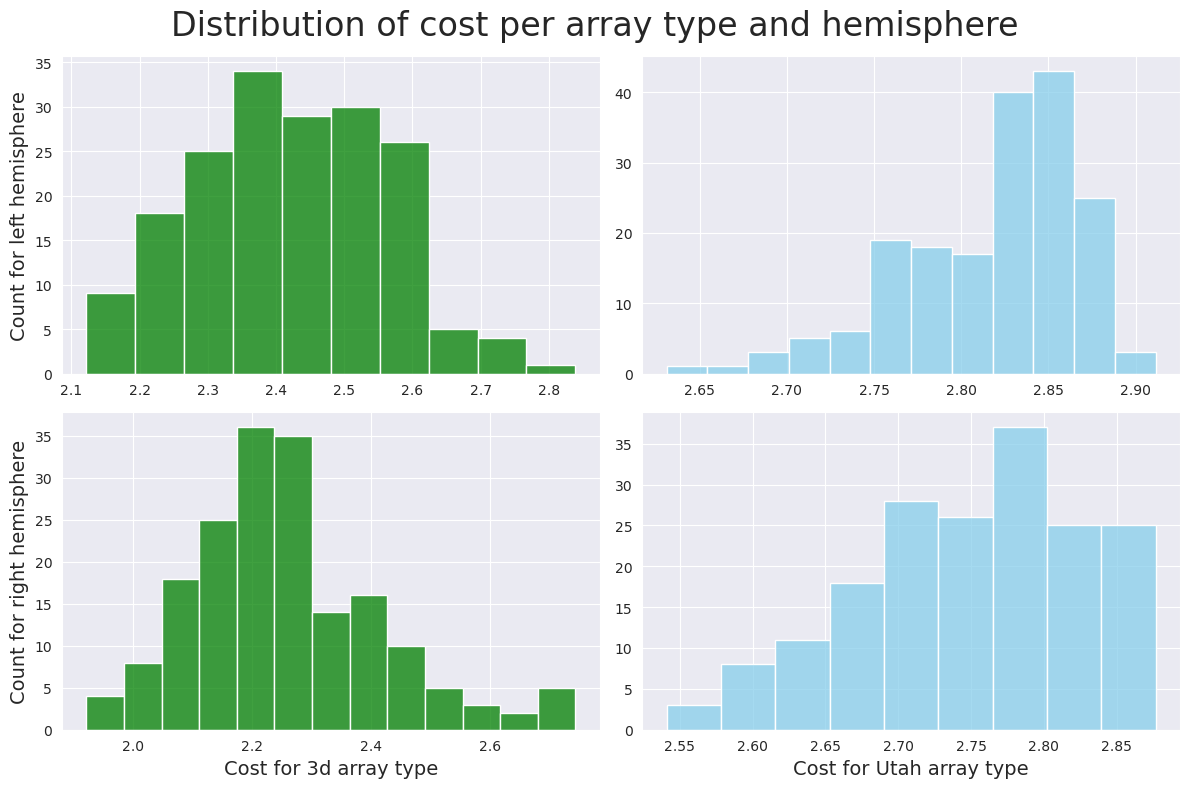

In [33]:
create_histograms(data)